In [3]:

%load_ext autoreload
%autoreload 2



In [4]:
from pathlib import Path
import os
try :
    from google.colab import drive
    from pathlib import Path
    import os

    # Montar Drive
    drive.mount('/content/drive')

    # Rutas posibles
    paths = [
        "/content/drive/MyDrive/Proyecto_final",
        "/content/drive/MyDrive/Accesos directos/Proyecto_final",
        "/content/drive/MyDrive/Shortcuts/Proyecto_final"
    ]


    # Buscar cuál existe
    for p in paths:
        if Path(p).exists():
            BASE_DIR = Path(p)
            print(f"✅ Proyecto encontrado en: {BASE_DIR}")
            os.chdir(BASE_DIR)
            break
    else:
        raise FileNotFoundError("⚠️ No se encontró la carpeta TP_Colorizacion. Revisá el nombre del acceso directo.")

    # Confirmar contenido
    print("📁 Archivos encontrados:")
    for f in list(BASE_DIR.iterdir())[:10]:
        print("  ", f.name)
    DATA_DIR = Path("/content/imagewoof2-160")

except ImportError:
    DATA_DIR = Path("/imagewoof2-160")

    print("Entorno local detectado.")


Entorno local detectado.


In [5]:
!rm -rf /content/imagewoof2-160  # limpia si existía
!cp -r "/content/drive/MyDrive/Proyecto_final/imagewoof2-160" /content/


cp: directory /content does not exist


In [6]:
import torch
print("CUDA disponible:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
!nvidia-smi


CUDA disponible: False
zsh:1: command not found: nvidia-smi


In [7]:
# =============================================
# Preparación del dataset Imagewoof para colorización
# =============================================
import os
from pathlib import Path
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from skimage.color import rgb2lab, lab2rgb
from PIL import Image
import matplotlib.pyplot as plt
from utils.utils import ImagewoofColorizationDataset




In [8]:
DATA_DIR = Path("imagewoof2-160")

# ---------------------------------------------
# Crear datasets
# ---------------------------------------------
train_dataset = ImagewoofColorizationDataset(DATA_DIR, split="train")
val_dataset   = ImagewoofColorizationDataset(DATA_DIR, split="val")

# ---------------------------------------------
# Crear DataLoaders (sin multiprocessing)
# ---------------------------------------------
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0)


In [9]:


print(f"Train samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset)}")

# ---------------------------------------------
# Probar una muestra del DataLoader
# ---------------------------------------------
L_batch, ab_batch = next(iter(train_loader))
print("Shape canal L:", L_batch.shape)   # [batch, 1, H, W]
print("Shape canales ab:", ab_batch.shape)  # [batch, 2, H, W]


Train samples: 9025
Val samples: 3929
Shape canal L: torch.Size([16, 1, 224, 224])
Shape canales ab: torch.Size([16, 2, 224, 224])


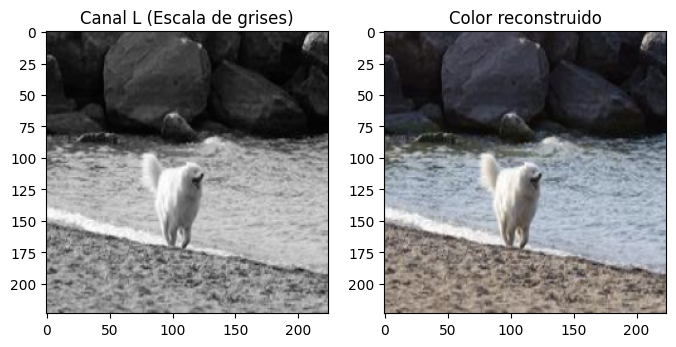

In [10]:
# ---------------------------------------------
# Visualizar una muestra reconstruida (opcional)
# ---------------------------------------------
L_sample = L_batch[2]
ab_sample = ab_batch[2]

# Reconstruir imagen RGB aproximada
lab = torch.cat((L_sample, ab_sample), dim=0).permute(1, 2, 0).numpy()
rgb = lab2rgb(lab * [100, 128, 128])

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(L_sample.squeeze(), cmap='gray')
plt.title("Canal L (Escala de grises)")

plt.subplot(1,2,2)
plt.imshow(rgb)
plt.title("Color reconstruido")
plt.show()


ENCODER

In [11]:
import torch.optim as optim
from tqdm import tqdm
from models.encoder import FastColorNet
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando:", device)

# Redimensionar imágenes a 128×128 para acelerar
train_dataset = ImagewoofColorizationDataset(DATA_DIR, img_size=128, split="train")
val_dataset   = ImagewoofColorizationDataset(DATA_DIR, img_size=128, split="val")

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=0)


Usando: cpu


In [12]:
!pip install pytorch-msssim


In [28]:
from utils.trainer import trainer

def train_model(model, train_loader, val_loader, save_name, criterion ="l1"):
    save_path = "pesos_entrenados"
    model_path = Path(save_path) / save_name

    train= False  # Cambia a True para forzar el reentrenamiento

    # Verificar si ya existe un modelo entrenado
    if model_path.exists() and not train:
        print(f"✅ Modelo ya entrenado encontrado en '{model_path}'.")
        print("No se vuelve a entrenar para evitar sobreescritura.")
    else:
        print("🚀 No se encontró modelo entrenado, iniciando entrenamiento...")
        trainer(
            model,
            train_loader,
            val_loader,
            epochs=10,
            save_path=save_path,
            save_name=save_name,
            criterion=criterion
        )
        print(f"💾 Modelo guardado en: {model_path}")

FASTCOLORNET 

In [24]:
model = FastColorNet()
save_name = "fastColorNet.pt"
train_model(model, train_loader, val_loader, save_name)


✅ Modelo ya entrenado encontrado en 'pesos_entrenados/fastColorNet.pt'.
No se vuelve a entrenar para evitar sobreescritura.


In [ ]:
from utils.visualize import visualize_colorization, visualize_ranked_colorizations
# Cargar mejor modelo si hace falta
model = FastColorNet()
model.load_state_dict(torch.load("pesos_entrenados/fastColorNet.pt"))
# Visualizar resultados
visualize_colorization(model, val_loader, num_samples=5)
visualize_ranked_colorizations(model, val_loader, num_each=3, criterion=nn.L1Loss(reduction="none"))


UNET con metrica L1

In [25]:
from models.unet import UNetColor

model = UNetColor()
save_name = "unetColor.pt"
train_model(model, train_loader, val_loader, save_name)


✅ Modelo ya entrenado encontrado en 'pesos_entrenados/unetColor.pt'.
No se vuelve a entrenar para evitar sobreescritura.


In [ ]:
model = UNetColor()
# Evita el error cuando el checkpoint fue guardado en GPU pero ahora estamos en CPU
state = torch.load("pesos_entrenados/unetColor.pt", map_location=device)
model.load_state_dict(state)
model.to(device)
model.eval()

visualize_colorization(model, val_loader, num_samples=5)

visualize_ranked_colorizations(model, val_loader, num_each=3, criterion=nn.L1Loss(reduction="none"))


UNET con metrica L1 + SSIM

In [29]:

# Configuración del modelo y ruta
model = UNetColor()
save_name = "unetColorSSIM.pt"
train_model(model, train_loader, val_loader, save_name, criterion='combined')

✅ Modelo ya entrenado encontrado en 'pesos_entrenados/unetColorSSIM.pt'.
No se vuelve a entrenar para evitar sobreescritura.


/Users/damiandistefano/Documents/UDESA/3_año/2_semestre/Vision artificial/TPs/Tp_final_vision/utils/visualize.py:27: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 793 negative Z values that have been clipped to zero
  return np.clip(lab2rgb(lab * [100, 128, 128]), 0, 1)
/Users/damiandistefano/Documents/UDESA/3_año/2_semestre/Vision artificial/TPs/Tp_final_vision/utils/visualize.py:27: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 2332 negative Z values that have been clipped to zero
  return np.clip(lab2rgb(lab * [100, 128, 128]), 0, 1)
/Users/damiandistefano/Documents/UDESA/3_año/2_semestre/Vision artificial/TPs/Tp_final_vision/utils/visualize.py:27: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 24 negative Z values that have been clipped to zero
  return np.clip(lab2rgb(lab * [100, 128, 128]), 0, 1)
/Users/damiandistefano/Documents/UDESA/3_año/2_semestre/Vision artificial/TPs/Tp_final_

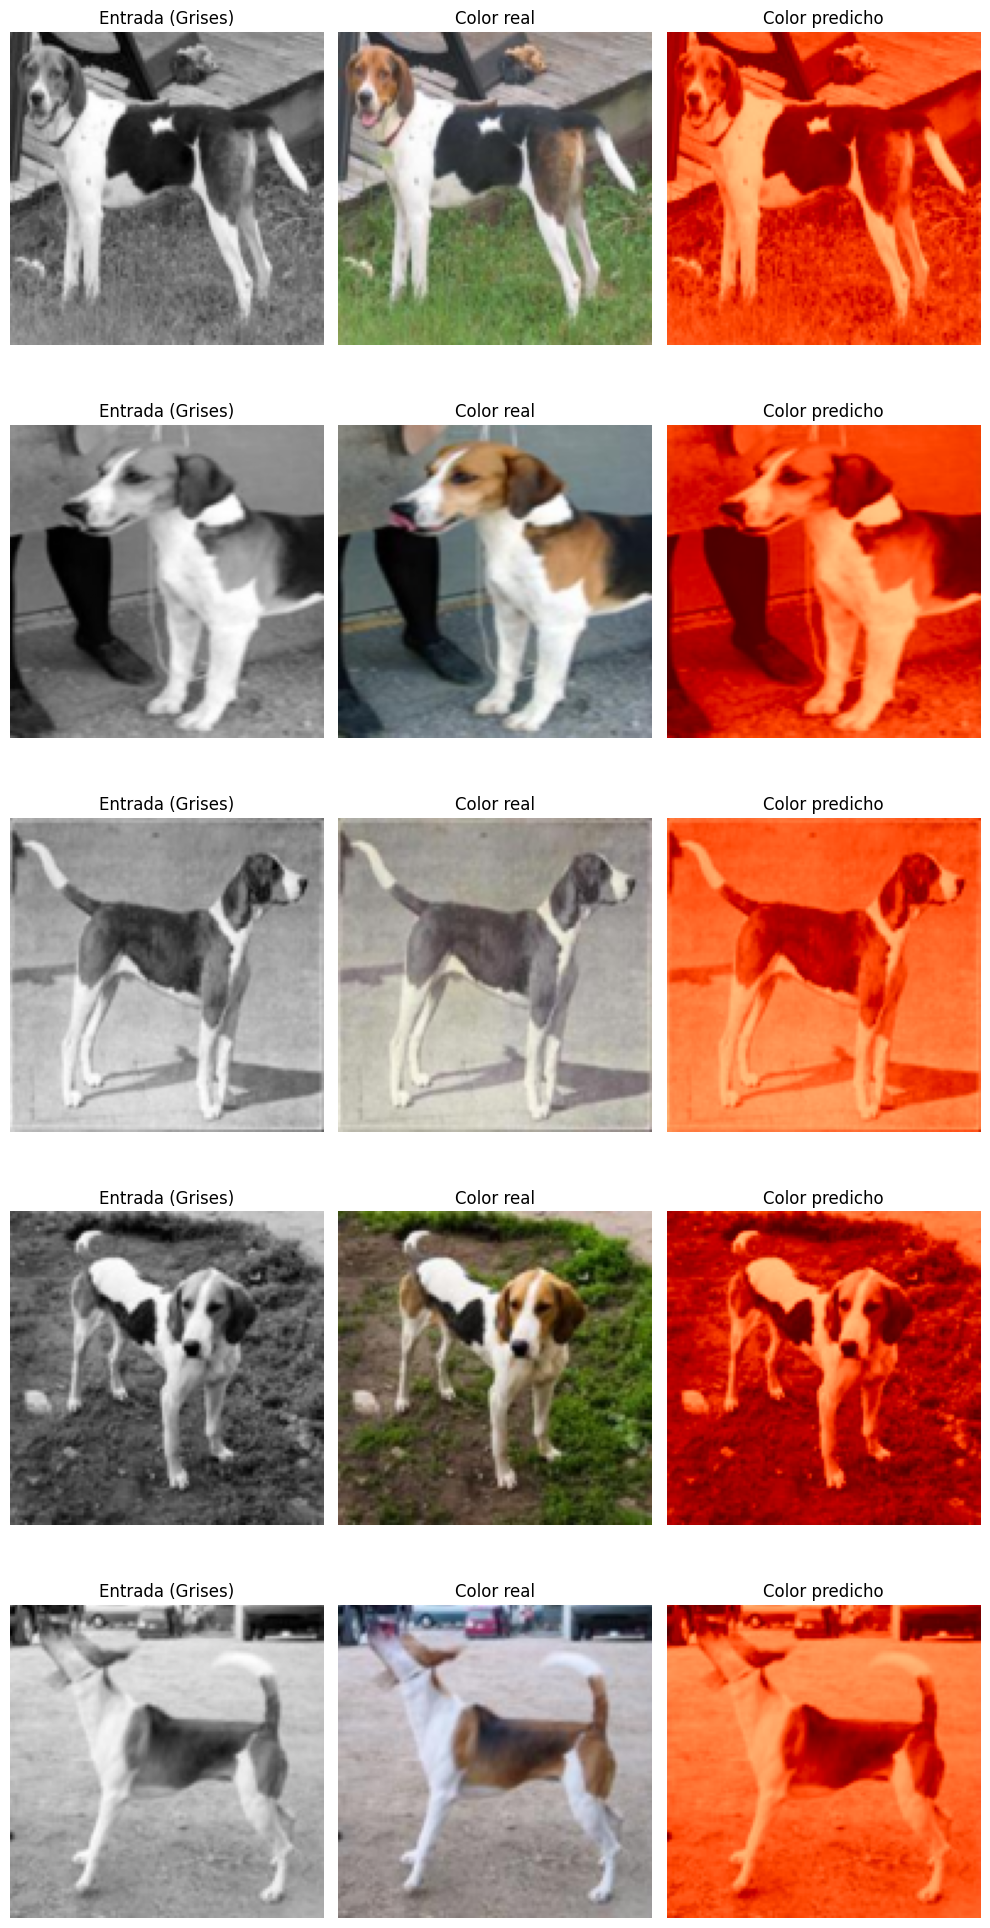

/Users/damiandistefano/Documents/UDESA/3_año/2_semestre/Vision artificial/TPs/Tp_final_vision/utils/visualize.py:107: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1823 negative Z values that have been clipped to zero
  return np.clip(lab2rgb(lab * [100, 128, 128]), 0, 1)
/Users/damiandistefano/Documents/UDESA/3_año/2_semestre/Vision artificial/TPs/Tp_final_vision/utils/visualize.py:107: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 252 negative Z values that have been clipped to zero
  return np.clip(lab2rgb(lab * [100, 128, 128]), 0, 1)
/Users/damiandistefano/Documents/UDESA/3_año/2_semestre/Vision artificial/TPs/Tp_final_vision/utils/visualize.py:107: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 104 negative Z values that have been clipped to zero
  return np.clip(lab2rgb(lab * [100, 128, 128]), 0, 1)
/Users/damiandistefano/Documents/UDESA/3_año/2_semestre/Vision artificial/TPs/Tp_fi

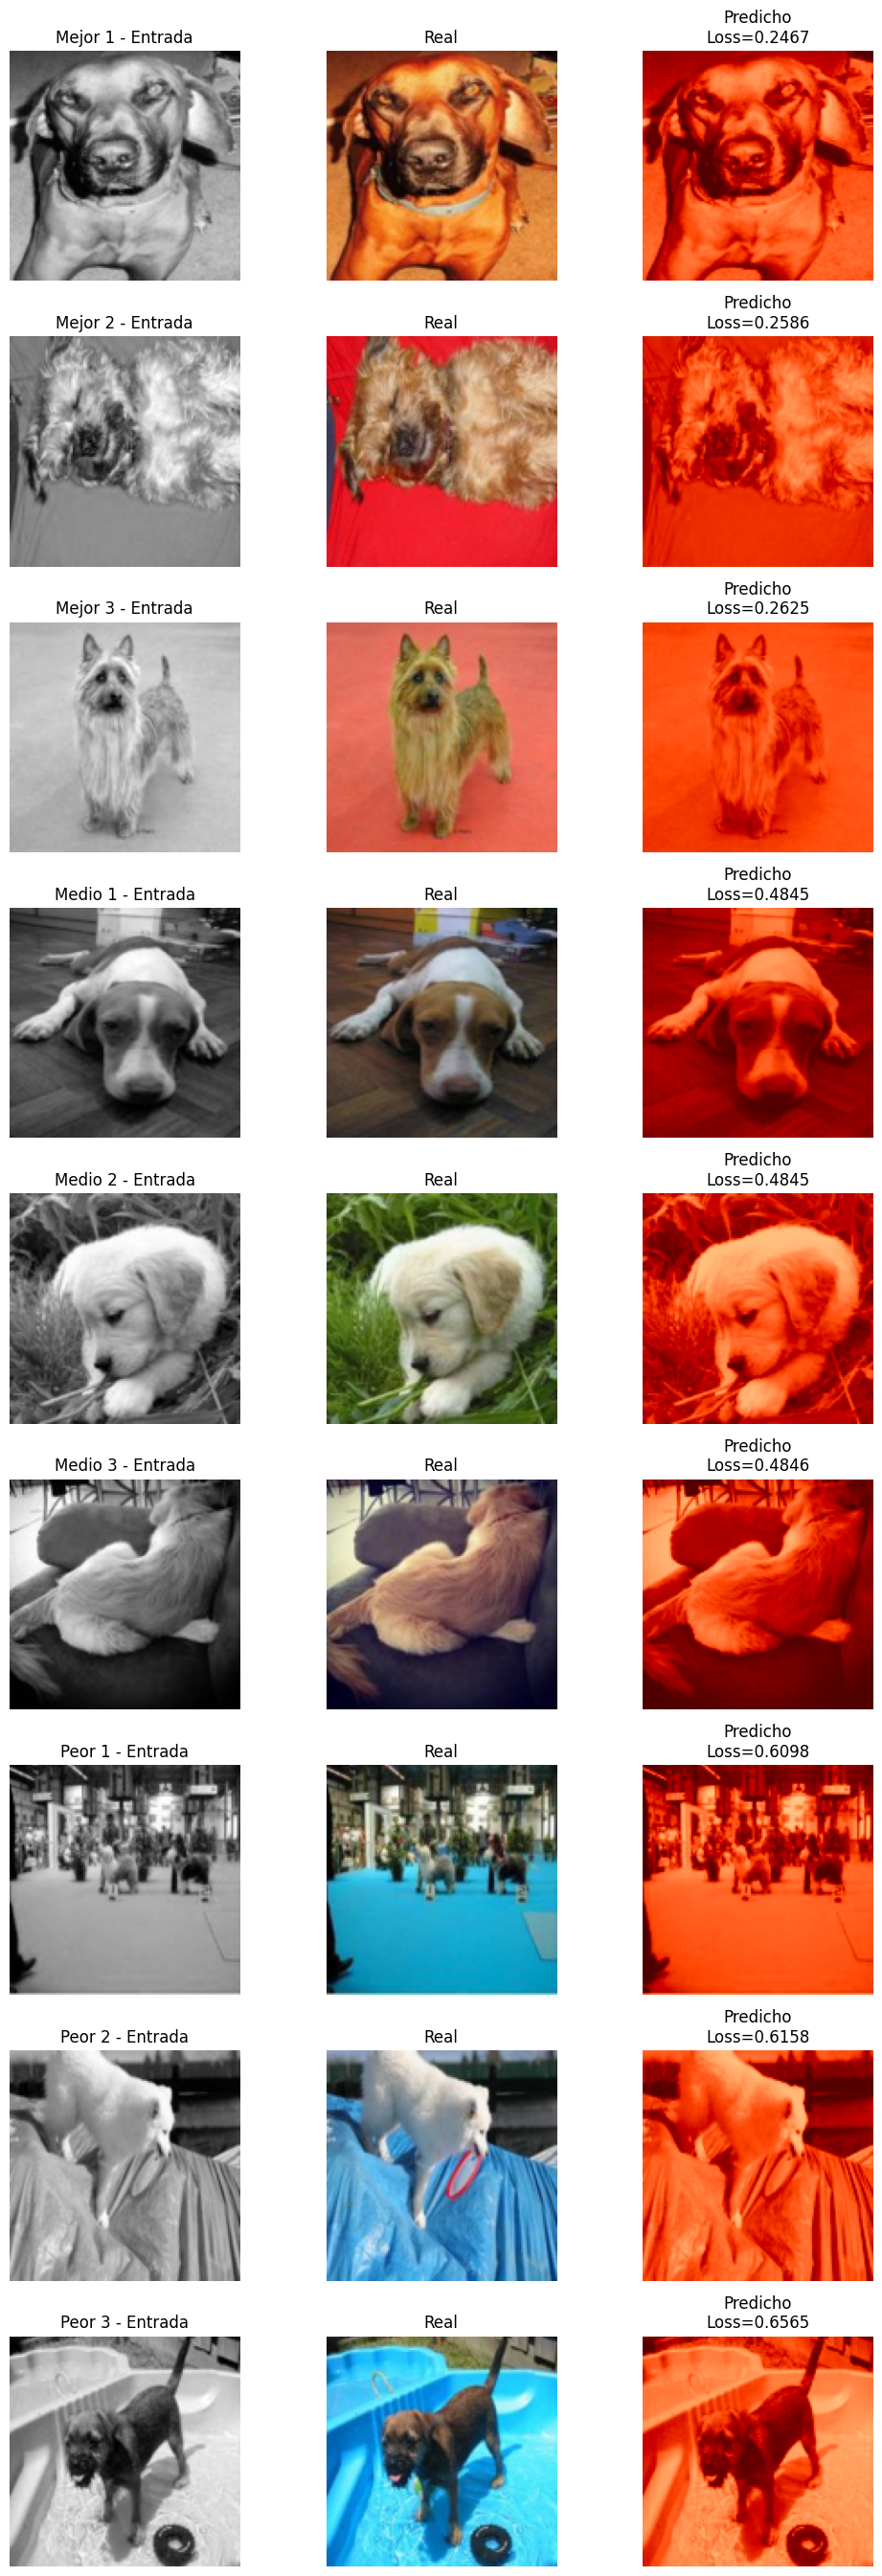

In [31]:
model = UNetColor()
state = torch.load("pesos_entrenados/unetColorSSIM.pt", map_location=device)
model.load_state_dict(state)
model.to(device)
model.eval()

visualize_colorization(model, val_loader, num_samples=5)

visualize_ranked_colorizations(model, val_loader, num_each=3, criterion=nn.L1Loss(reduction="none"))


In [ ]:
import os
import shutil
from pathlib import Path

# --- Configuración de carpetas ---
LOCAL_SAVE_DIR = Path("/content/pesos_entrenados")
RESULTS_DIR = Path("/content/resultados")

DRIVE_SAVE_DIR = Path("/content/drive/MyDrive/Proyecto_final/pesos_entrenados")
DRIVE_RESULTS_DIR = Path("/content/drive/MyDrive/Proyecto_final/resultados")

def backup_to_drive():
    """
    Copia los modelos y resultados desde el almacenamiento local (/content/)
    al Google Drive del proyecto.
    """
    # Crear carpetas destino si no existen
    DRIVE_SAVE_DIR.mkdir(parents=True, exist_ok=True)
    DRIVE_RESULTS_DIR.mkdir(parents=True, exist_ok=True)

    # Copiar modelos entrenados
    if LOCAL_SAVE_DIR.exists():
        print(f"📤 Copiando modelos desde {LOCAL_SAVE_DIR} → {DRIVE_SAVE_DIR}")
        for file in LOCAL_SAVE_DIR.glob("*.pt"):
            shutil.copy(file, DRIVE_SAVE_DIR)
            print(f"   ✅ {file.name} guardado en Drive")

    # Copiar resultados (gráficos, imágenes, etc.)
    if RESULTS_DIR.exists():
        print(f"📸 Copiando resultados desde {RESULTS_DIR} → {DRIVE_RESULTS_DIR}")
        for file in RESULTS_DIR.glob("*"):
            shutil.copy(file, DRIVE_RESULTS_DIR / file.name)
            print(f"   ✅ {file.name} guardado en Drive")

    print("✅ Backup completo en Google Drive.")

# --- Ejecutar al final del entrenamiento ---
backup_to_drive()


RED CON UN ENCODER PRE-ENTRENADO

Unet con un encoder resnet34 entrenado en ImageNet

In [ ]:
!pip install segmentation-models-pytorch

  Using cached idna-3.11-py3-none-any.whl.metadata (8.4 kB)
  Using cached click-8.3.0-py3-none-any.whl.metadata (2.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 10.8 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 11.0 MB/s  0:00:00 eta 0:00:01
Using cached idna-3.11-py3-none-any.whl (71 kB)
Using cached click-8.3.0-py3-none-any.whl (107 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16/16 [segmentation-models-pytorch]e-hub]


In [ ]:
# ============================================= da
from models.unet_resnet34 import get_model_unet_resnet34

model = get_model_unet_resnet34()

save_name = "unet_resnet34.pt"
train_model(model, train_loader, val_loader, save_name)
